In [1]:
# tax 78 % på NPV på petroleum
# tax 22 % yearly på profit for WC (med fremførbart underskudd)

##### TODO
 - Legg inn eksisterende bilder i Overleaf
 - Legge til tax
 - Lag siste bilder
 - LCOE 2031 sensitivity
 - Forringelse https://www.nve.no/media/17785/metode-og-forutsetninger-for-beregning-av-kostnader-for-kraftproduksjon.pdf#page=1

## Imports

In [2]:
from scipy.optimize import brentq
from simulib.cash_flow_models import *
from simulib.visualize import *

## Calc LCOE given net CAPEX (Gov't support - CAPEX)

In [3]:
a = get_discounted_power_production(
        wind_annual_power_production = 69032.25,
        t_construction = 2, LT_field = 26,
        discount_rate = 0.07
    ),
b = net_present_value([0, 9] + 25*[100], 0.07)

print(b/a*1000*1000)

[1459.78574731]


## Simulation Results

In [4]:
W = 1000 # number of simulation paths

In [5]:
wc_simulation = MonteCarlo(WindContractorPath, 1)
fo_simulation = MonteCarlo(FieldOperatorPath, W)

WindContractorPath Simulation complete at 0 ms
FieldOperatorPath Simulation complete at 31 ms


### Gas

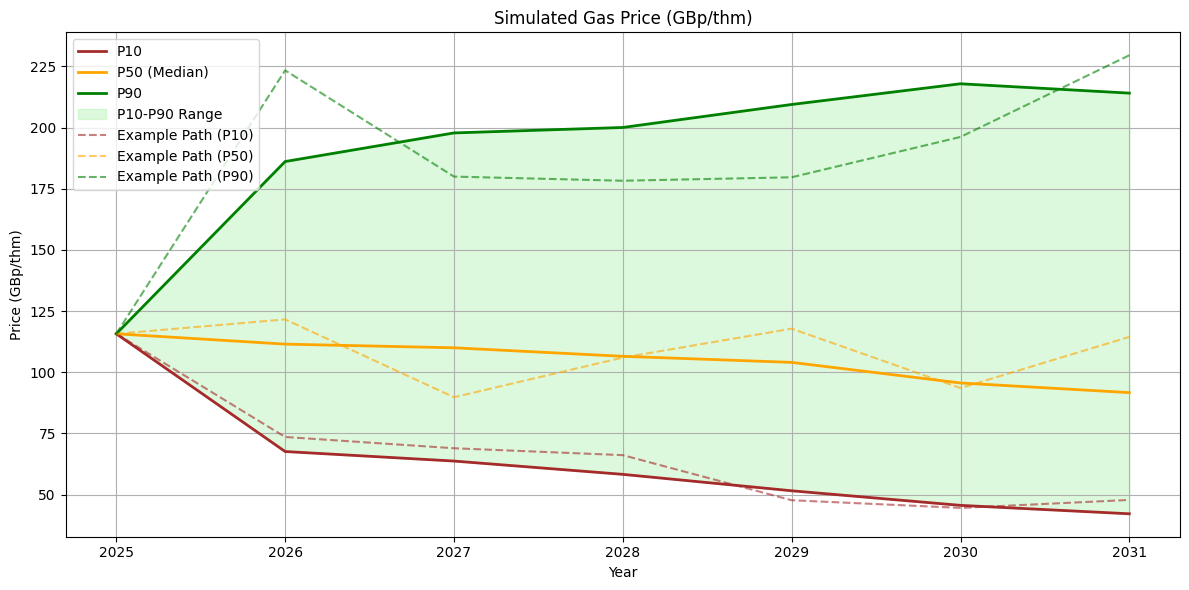

In [6]:
years = np.arange(2025, 2026+kwargs["LT_field"])
num_paths = W
state_variable_paths = np.array([path.state_variables["P_gas"] for path in fo_simulation.paths])

# Call the function
plot_state_variable_paths(
    years, 
    state_variable_paths, 
    title="Simulated Gas Price (GBp/thm)", 
    ylabel="Price (GBp/thm)"
)


### Carbon

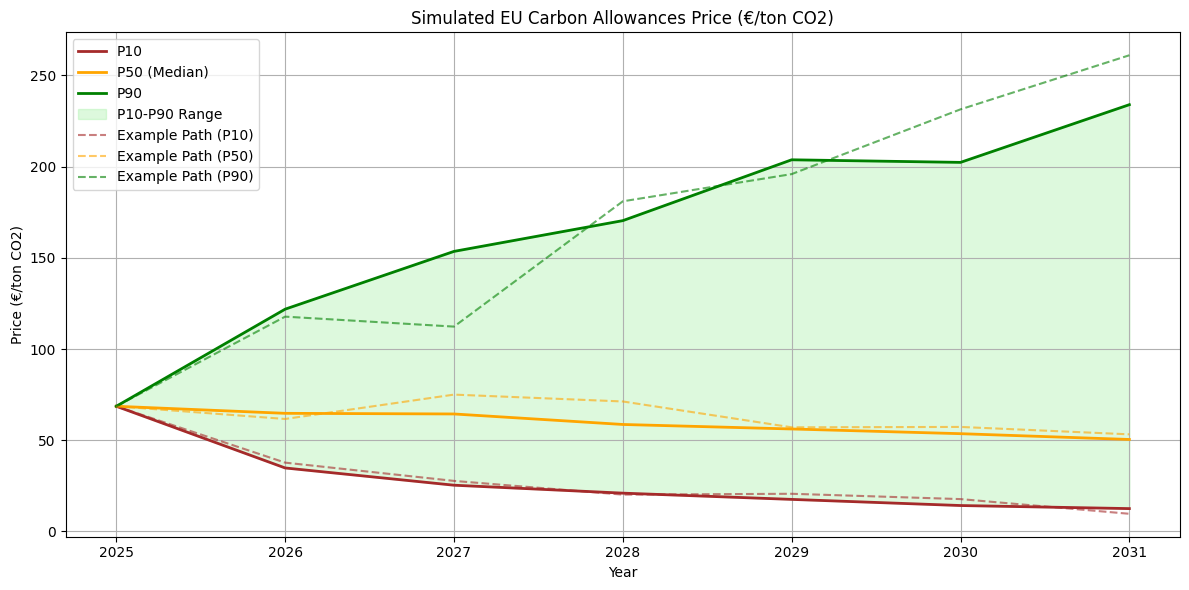

In [7]:
years = np.arange(2025, 2026+kwargs["LT_field"])
num_paths = W
state_variable_paths = np.array([path.state_variables["P_ets"] for path in fo_simulation.paths])

# Call the function
plot_state_variable_paths(
    years, 
    state_variable_paths, 
    title="Simulated EU Carbon Allowances Price (€/ton CO2)", 
    ylabel="Price (€/ton CO2)"
)


## Standard Case Results

In [8]:
# kwargs["CAPEX_support"] = 2000 * 10**6

In [9]:
ppa_price = 2000 # kr/MWh basert på utsira Nord "high"-case

In [10]:
npv_wc = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs)
npv_fo = fo_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs)
print_currency_array("NPV WC", npv_wc)
print_currency_array("NPV FO", npv_fo)
print("NPV FO", f"{int(np.mean(npv_fo) / 1e6):,}".replace(",", " "))
print("NPV Net:", f"{int((np.mean(npv_wc) + np.mean(npv_fo)) / 1e6):,}".replace(",", " "))

NPV WC ['414']
NPV FO ['519', '628', '551', '357', '488', '423', '275', '411', '409', '655', '502', '486', '714', '688', '422', '1 247', '685', '815', '840', '429', '336', '497', '773', '568', '811', '572', '488', '546', '411', '457', '447', '526', '471', '326', '641', '589', '464', '619', '1 140', '462', '327', '374', '913', '345', '306', '445', '702', '346', '519', '861', '416', '762', '649', '560', '445', '761', '338', '600', '338', '851', '461', '531', '435', '942', '546', '657', '374', '508', '731', '329', '808', '536', '526', '303', '418', '581', '457', '414', '367', '505', '550', '877', '501', '588', '353', '372', '421', '597', '1 007', '359', '432', '574', '441', '521', '554', '481', '422', '434', '522', '401', '620', '317', '806', '397', '591', '422', '626', '699', '251', '604', '736', '583', '460', '311', '928', '582', '830', '588', '476', '482', '454', '464', '508', '535', '743', '739', '610', '554', '1 076', '824', '407', '553', '500', '476', '480', '364', '451', '417', '94

### Wind Contractor Cash Flows

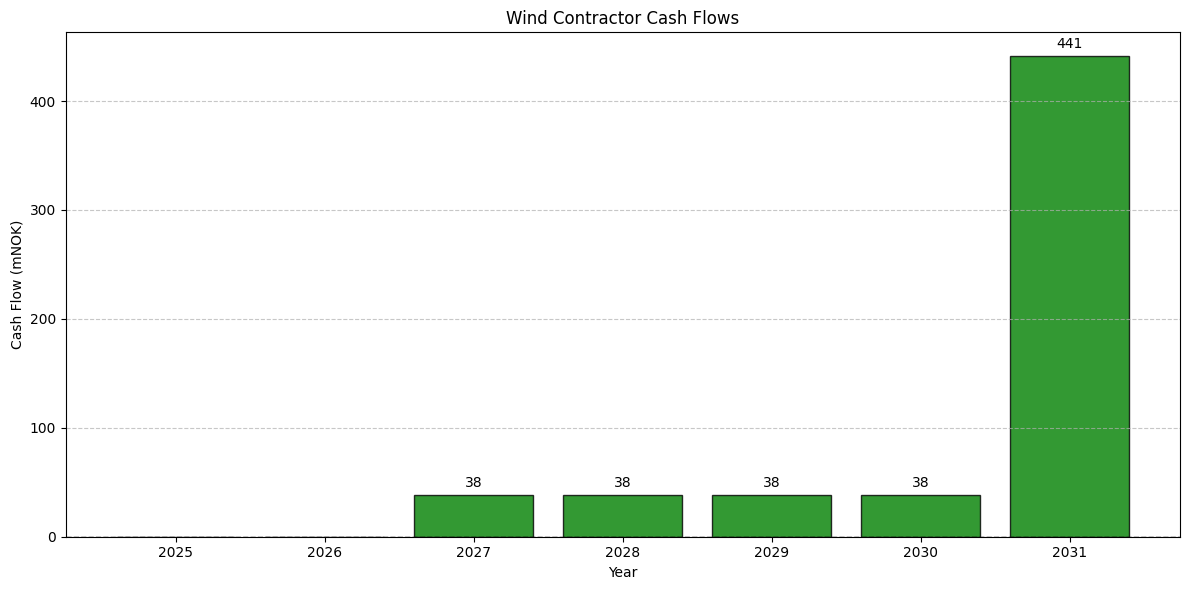

In [11]:
years = np.arange(2025, 2026+kwargs["LT_field"])
num_paths = W
cash_flows = wc_simulation.paths[0].cash_flows/1000000

# Call the function
plot_cash_flows(
    years, 
    cash_flows, 
    title="Wind Contractor Cash Flows", 
    ylabel="Cash Flow (mNOK)"
)


### Field Operator Cash Flows

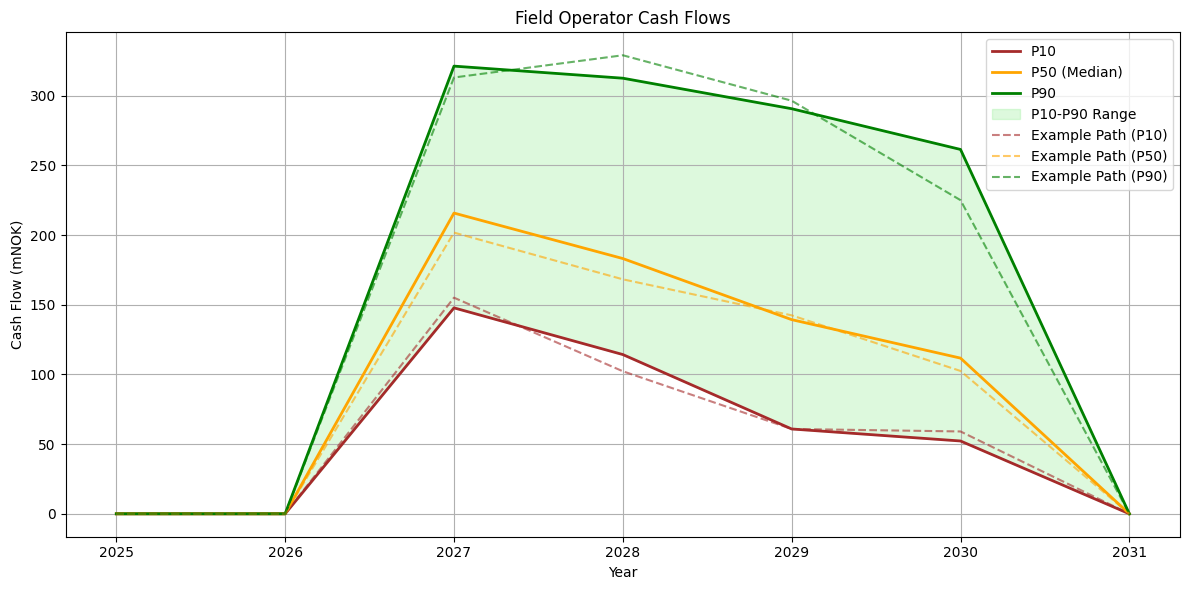

In [12]:
years = np.arange(2025, 2032)
num_paths = W
state_variable_paths = np.array([path.cash_flows/1000000 for path in fo_simulation.paths])

# Call the function
plot_state_variable_paths(
    years, 
    state_variable_paths, 
    title="Field Operator Cash Flows", 
    ylabel="Cash Flow (mNOK)"
)


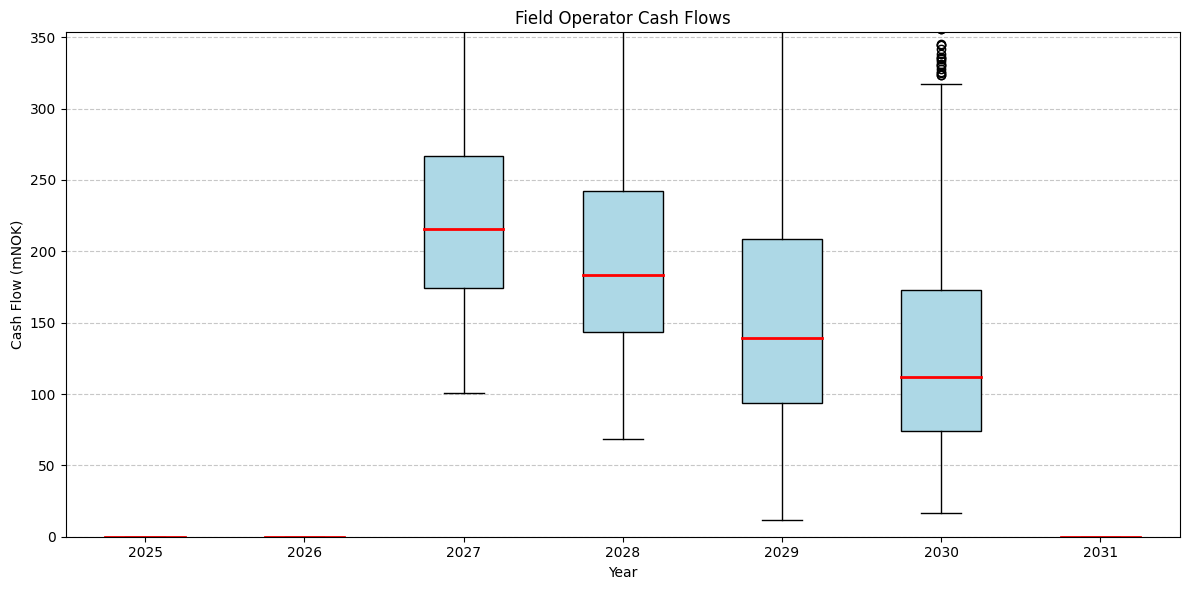

In [13]:
years = np.arange(2025, 2032)
num_paths = W
state_variable_paths = np.array([path.cash_flows/1000000 for path in fo_simulation.paths])

# Call the function
plot_state_variable_boxplots(
    years, 
    state_variable_paths, 
    title="Field Operator Cash Flows", 
    ylabel="Cash Flow (mNOK)"
)


# Sensitivity Analyses

## CAPEX

In [14]:
CAPEX_low = 000 * 10**6
CAPEX_high = 5000 * 10**6

### Wind Operator

In [15]:
def objective(CAPEX):
    kwargs_copy = kwargs.copy()
    kwargs_copy["CAPEX"] = CAPEX
    npv = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy)[0]
    return npv

zero_level = brentq(objective, CAPEX_low, CAPEX_high)

In [16]:
int(zero_level/1000000)

2428

### Net Project

In [17]:
zero_levels = []

for path in fo_simulation.paths:
    def objective(CAPEX):
        kwargs_copy = kwargs.copy()
        kwargs_copy["CAPEX"] = CAPEX
        npv_wc = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy)[0]
        npv_fo = path.calculate_cash_flows(ppa_price = ppa_price, **kwargs_copy)
        return (npv_wc + npv_fo)

    zero_levels.append(brentq(objective, CAPEX_low, CAPEX_high)/1000000)

In [18]:
np.quantile(zero_levels, 0.1)

2797.201638408377

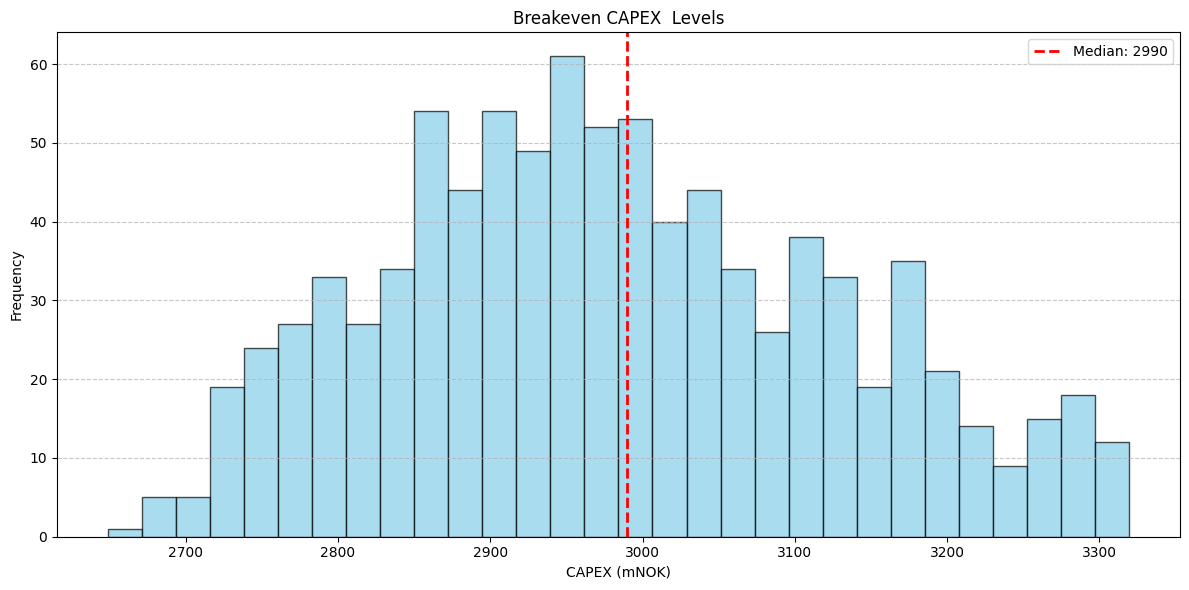

In [19]:
plot_breakeven_histogram(
    zero_levels, 
    title="Breakeven CAPEX  Levels", 
    xlabel="CAPEX (mNOK)"
)

## PPA-price

In [20]:
ppa_low = 0
ppa_high = 100000

### Wind Contractor

In [21]:
CAPEX_line = [2000 * 10**6, 4000 * 10**6]
zero_level_line = []

In [22]:
default_CAPEX = kwargs["CAPEX"]
for CAPEX in CAPEX_line:
    kwargs["CAPEX"] = CAPEX
    def objective(ppa_price):
        kwargs_copy = kwargs.copy()
        # kwargs_copy["CAPEX"] = CAPEX
        npv = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy)[0]
        return npv

    zero_level_line.append(brentq(objective, ppa_low, ppa_high))

kwargs["CAPEX"] = default_CAPEX

In [23]:
zero_level_line

[103.8983513121887, 8956.604173608805]

### Field Operator

In [24]:
zero_levels = []

for path in fo_simulation.paths:
    def objective(ppa_price):
        kwargs_copy = kwargs.copy()
        # kwargs_copy["CAPEX"] = CAPEX
        npv = path.calculate_cash_flows(ppa_price = ppa_price, **kwargs_copy)
        return npv

    zero_levels.append(brentq(objective, ppa_low, ppa_high))

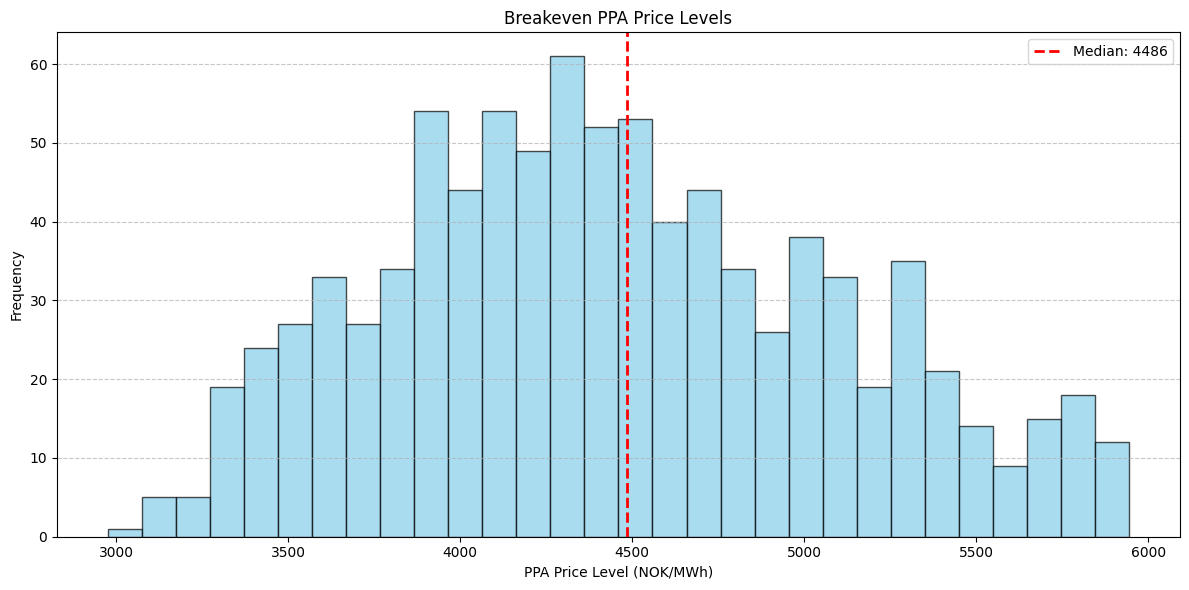

In [25]:
plot_breakeven_histogram(
    zero_levels, 
    title="Breakeven PPA Price Levels", 
    xlabel="PPA Price Level (NOK/MWh)"
)

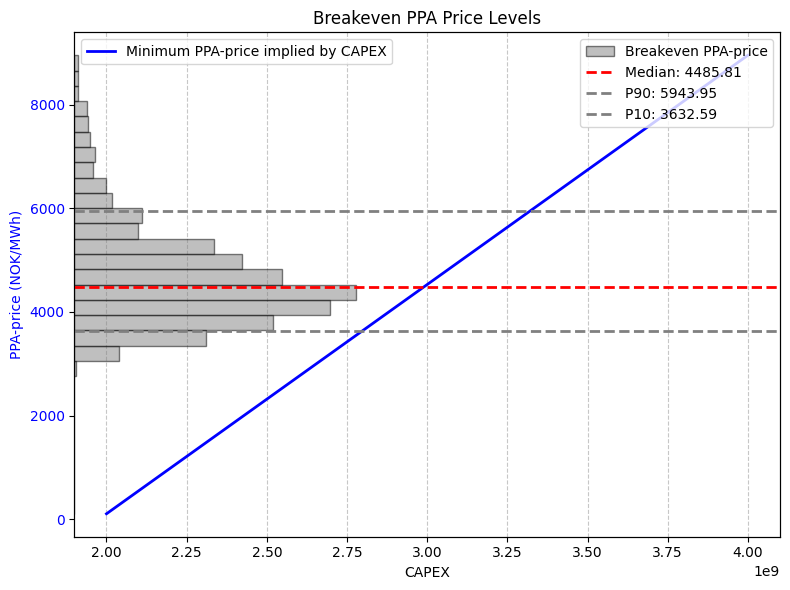

In [26]:
plot_histogram_with_line(
    CAPEX_line, zero_level_line, zero_levels,
    line_label="Minimum PPA-price implied by CAPEX", histogram_label="Breakeven PPA-price",
    x_label_line="CAPEX", y_label_line="PPA-price (NOK/MWh)",
    title="Breakeven PPA Price Levels"
    )

## Resale Value

In [27]:
wind_residual_value_low = -10000 * 10**6
wind_residual_value_high = 10000 * 10**6

### Wind Operator

In [28]:
objective(0)

1183492622.8053277

In [29]:
def objective(wind_residual_value):
    kwargs_copy = kwargs.copy()
    kwargs_copy["wind_residual_value"] = wind_residual_value
    npv = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy)[0]
    return npv

zero_level = brentq(objective, wind_residual_value_low, wind_residual_value_high)

In [30]:
int(zero_level/1000000)

-180

### Net Project

In [65]:
zero_levels = []

for path in fo_simulation.paths:
    def objective(wind_residual_value):
        kwargs_copy2 = kwargs.copy()
        kwargs_copy2["wind_residual_value"] = wind_residual_value
        npv_wc = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy2)[0]
        npv_fo = path.calculate_cash_flows(ppa_price = ppa_price, **kwargs_copy2)
        return (npv_wc + npv_fo)

    zero_levels.append(brentq(objective, wind_residual_value_low, wind_residual_value_high)/1000000)

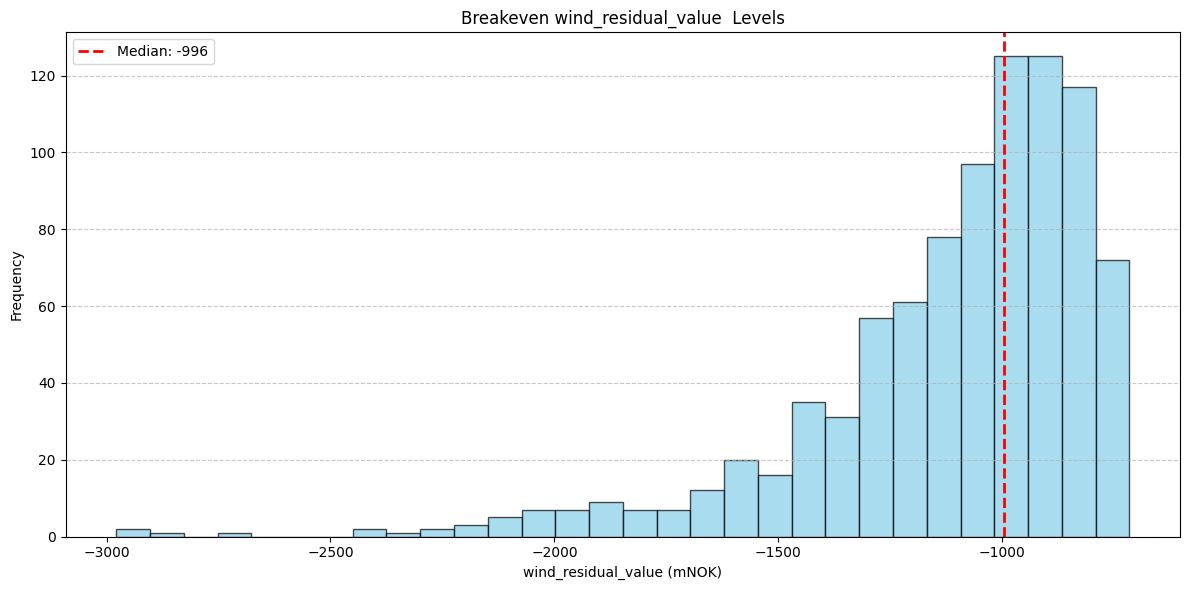

In [66]:
plot_breakeven_histogram(
    zero_levels, 
    title="Breakeven wind_residual_value  Levels", 
    xlabel="wind_residual_value (mNOK)"
)

### CAPEX vs Residual Value

In [ ]:
resid_levels_50 = []
resid_levels_90 = []
capex_levels = np.arange(2000, 4001, 2000) * 10 ** 6
for CAPEX in capex_levels:
    kwargs_copy = kwargs.copy()
    kwargs_copy["CAPEX"] = CAPEX

    zero_levels = []

    for path in fo_simulation.paths:
        def objective(wind_residual_value):
            kwargs_copy2 = kwargs_copy.copy()
            kwargs_copy2["wind_residual_value"] = wind_residual_value
            npv_wc = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy2)[0]
            npv_fo = path.calculate_cash_flows(ppa_price = ppa_price, **kwargs_copy2)
            return (npv_wc + npv_fo)

        zero_levels.append(brentq(objective, wind_residual_value_low, wind_residual_value_high)/1000000)
    
    resid_levels_50.append(np.median(zero_levels))
    resid_levels_90.append(np.quantile(zero_levels, 0.9))

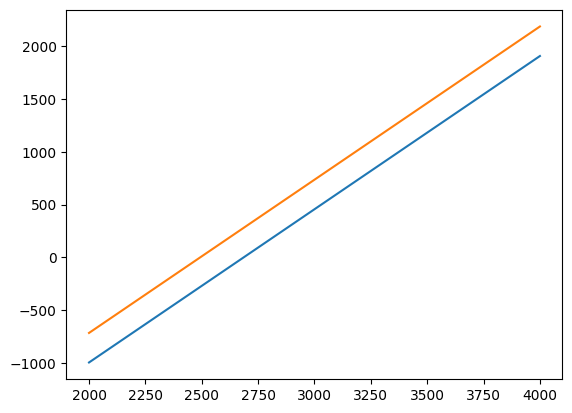

In [ ]:
plt.plot(capex_levels/(10**6), resid_levels_50)
plt.plot(capex_levels/(10**6), resid_levels_90)

***
***
# Junkyard
***


### Net Project

In [33]:
zero_levels = []

num_npv_negative = 0

for path in fo_simulation.paths:
    def objective(ppa_price):
        kwargs_copy = kwargs.copy()
        npv_wc = wc_simulation.calculate_all_cash_flows(ppa_price = ppa_price, **kwargs_copy)[0]
        npv_fo = path.calculate_cash_flows(ppa_price = ppa_price, **kwargs_copy)
        print(npv_wc, npv_fo, npv_wc + npv_fo)
        return (npv_wc - npv_fo)
    
    zero_levels.append(brentq(objective, ppa_low, ppa_high))
    # except ValueError:
    #     num_npv_negative += 1
    #     continue


-22704878.966443717 956154263.709393 933449384.7429492
21830268416.270172 -20896819031.52722 933449384.7429504
466724692.37147474 466724692.3714747 933449384.7429495
466724692.3714743 466724692.37147504 933449384.7429494
-22704878.966443717 1065178442.844238 1042473563.8777943
21830268416.270172 -20787794852.392376 1042473563.8777962
521236781.93889713 521236781.9388972 1042473563.8777943
521236781.9388976 521236781.93889666 1042473563.8777943
-22704878.966443717 988369245.7848836 965664366.81844
21830268416.270172 -20864604049.45173 965664366.8184433
482832183.4092199 482832183.40921986 965664366.8184397
482832183.40921956 482832183.4092203 965664366.8184398
-22704878.966443717 794271461.8880508 771566582.921607
21830268416.270172 -21058701833.348564 771566582.921608
385783291.4608035 385783291.46080357 771566582.921607
385783291.4608039 385783291.46080315 771566582.921607
-22704878.966443717 925864849.4132692 903159970.4468255
21830268416.270172 -20927108445.823345 903159970.4468269


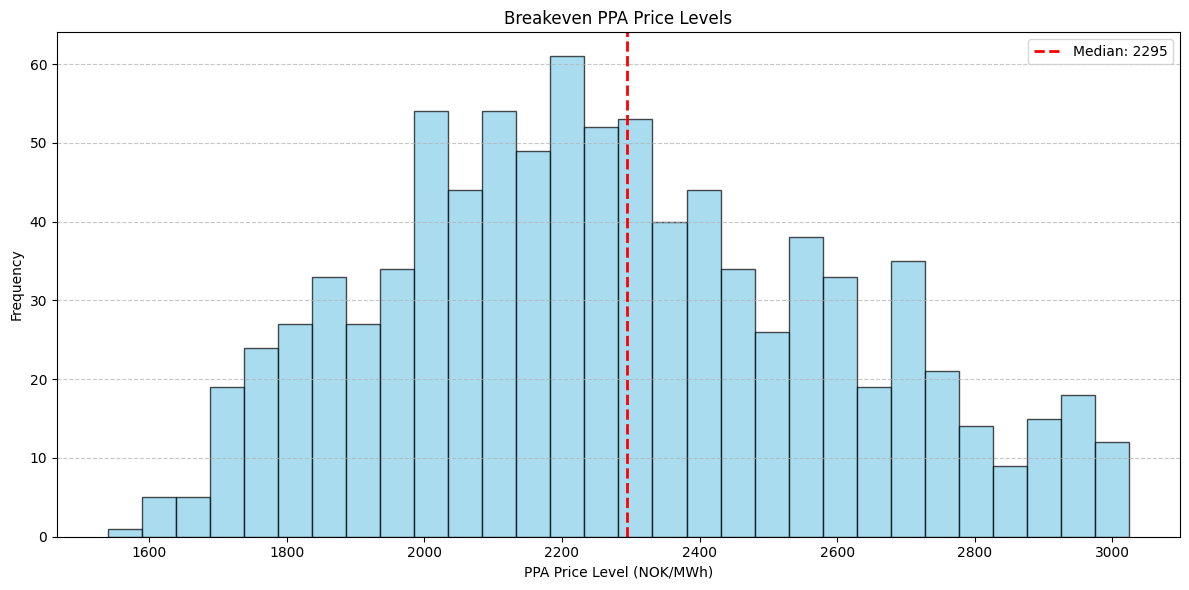

In [34]:
plot_breakeven_histogram(
    zero_levels, 
    title="Breakeven PPA Price Levels", 
    xlabel="PPA Price Level (NOK/MWh)"
)